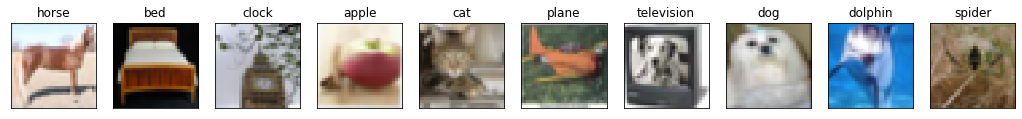

In [56]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
    fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
    plt.subplot(1, 10, i+1)
    img = plt.imread(f'./real_or_drawing/train_data/{i}/{500*i}.bmp')
    no_axis_show(img, titles[i])

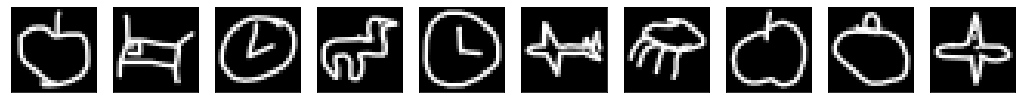

In [57]:
plt.figure(figsize=(18, 18))
for i in range(10):
    plt.subplot(1, 10, i+1)
    fig = no_axis_show(plt.imread(f'./real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

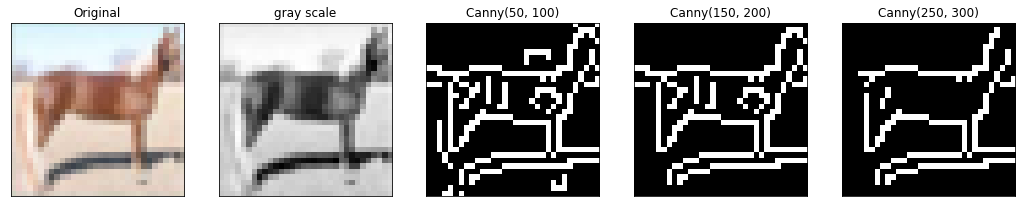

In [58]:
import cv2
import matplotlib.pyplot as plt

img = plt.imread('./real_or_drawing/train_data/0/0.bmp')
plt.figure(figsize = (18, 18))
plt.subplot(1, 5, 1)
no_axis_show(img, 'Original')

gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, 'gray scale', cmap='gray')

canny50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny50100, 'Canny(50, 100)', cmap='gray')

canny150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny150200, 'Canny(150, 200)', cmap='gray')

canny250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny250300, 'Canny(250, 300)', cmap='gray')

In [59]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

source_trans = transforms.Compose([
    transforms.Grayscale(),
    transforms.Lambda(lambda x : cv2.Canny(np.array(x), 170, 300)),
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15, fill=(0,)),
    transforms.ToTensor()
])

target_trans = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15, fill=(0,)),
    transforms.ToTensor()
])

source_set = ImageFolder('./real_or_drawing/train_data', transform=source_trans)
target_set = ImageFolder('./real_or_drawing/test_data', transform=target_trans)

source_loader = DataLoader(source_set, batch_size=32, shuffle=True)
target_loader = DataLoader(target_set, batch_size=32, shuffle=True)
test_loader = DataLoader(target_set, batch_size=128, shuffle=False)

In [43]:
import random
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(1116)

In [44]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):
    def __init__(self):
        super(LabelPredictor, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            
            nn.Linear(512, 512),
            nn.ReLU(),
            
            nn.Linear(512, 10),
        )
    
    def forward(self, x):
        x = self.layer(x)
        return x

class DomainClassifier(nn.Module):
    def __init__(self):
        super(DomainClassifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            
            nn.Linear(512, 1),
        )
    
    def forward(self, x):
        x = self.layer(x)
        return x

In [45]:
def adaptive_lambda(epoch, num_epoch):
    p = epoch / num_epoch
    return 2. / (1+np.exp(-10*p)) - 1

In [46]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_L = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

In [47]:
def train_epoch(source_loader, target_loader, lamb):
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0, 0
    
    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_loader, target_loader)):
        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([mixed_data.shape[0], 1]).cuda()
        domain_label[:source_data.shape[0]] = 1
        
        features = feature_extractor(mixed_data)
        domain_logits = domain_classifier(features.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss += loss.item()
        loss.backward()
        optimizer_D.step()
        
        class_logits = label_predictor(features[:source_data.shape[0]])
        domain_logits = domain_classifier(features)
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss += loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_L.step()
        
        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_L.zero_grad()
        
        total_hit += (class_logits.argmax(dim=1) == source_label).sum().item()
        total_num += source_data.shape[0]
        print(i, end='\r')
    
    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

num_epoch = 2000
for epoch in range(num_epoch):
    lamb = adaptive_lambda(epoch, num_epoch)
    train_D_loss, train_F_loss, train_acc =  train_epoch(source_loader, target_loader, lamb)
    torch.save(feature_extractor.state_dict(), 'extractor_model.bin')
    torch.save(label_predictor.state_dict(), 'predictor_model.bin')
    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc: {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))

epoch   0: train D loss: 0.1416, train F loss: 1.9411, acc: 0.2780
epoch   1: train D loss: 0.1935, train F loss: 1.6095, acc: 0.4292
epoch   2: train D loss: 0.2055, train F loss: 1.4934, acc: 0.4812
epoch   3: train D loss: 0.1950, train F loss: 1.4099, acc: 0.5048
epoch   4: train D loss: 0.2007, train F loss: 1.3454, acc: 0.5354
epoch   5: train D loss: 0.2281, train F loss: 1.2964, acc: 0.5474
epoch   6: train D loss: 0.2001, train F loss: 1.2531, acc: 0.5632
epoch   7: train D loss: 0.1971, train F loss: 1.2214, acc: 0.5724
epoch   8: train D loss: 0.2106, train F loss: 1.1686, acc: 0.5864
epoch   9: train D loss: 0.2368, train F loss: 1.1666, acc: 0.5906
epoch  10: train D loss: 0.2437, train F loss: 1.1057, acc: 0.6092
epoch  11: train D loss: 0.2594, train F loss: 1.0746, acc: 0.6268
epoch  12: train D loss: 0.2504, train F loss: 1.0497, acc: 0.6238
epoch  13: train D loss: 0.2732, train F loss: 1.0000, acc: 0.6472
epoch  14: train D loss: 0.2539, train F loss: 0.9911, acc: 0.

In [55]:
result = []
feature_extractor.eval()
label_predictor.eval()

for i, (test_data, _) in enumerate(test_loader):
    test_data = test_data.cuda()
    logits = label_predictor(feature_extractor(test_data))
    pred = logits.argmax(dim=1).cpu().detach().numpy()
    result.append(pred)

import pandas as pd
result = np.concatenate(result)

df = pd.DataFrame({'id': np.arange(0, len(result)), 'label': result})
df.to_csv('DaNN_submission.csv', index=False)